In [1]:
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
seed = 42
np.random.seed(seed)

from sklearn.cluster import KMeans

In [2]:
save_dir = "./assets/assignment2/"
ques = ["Q1/", "Q2/", "Q3/", "Q4/"]
save_dirs = [save_dir + q for q in ques]
for save_dir in save_dirs:
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

## Question 3

Q3. Create a 1-dimensional dataset in the following manner – pick 100 samples from each of following two Gaussians.

<div style="margin-left: 25px;">
(a) mean = 0, variance = 1. 
<br> 
(b) mean = 3, variance = 1.  
</div>

Use sklearn’s implementation for kmeans. First try k-means on this data using $k = 2$. What are the centers? What fraction of points are correctly classified?

Now, suppose we want to use distance rather than squared distance (i.e., k-median). Let us do an exhaustive search over all 2-clusterings (left $s$ points in one cluster and rest $200 - s$ in the other cluster). Find the best one according to the k-median objective. What are the centers? Did distance work better or the squared distance?

In [3]:
samples_a = np.random.normal(loc=0, scale=1, size=100)
samples_b = np.random.normal(loc=3, scale=1, size=100)
X = np.concatenate((samples_a, samples_b)).reshape(-1, 1)
y = np.array([0]*100 + [1]*100)
np.save(save_dirs[2] + "X.npy", X)

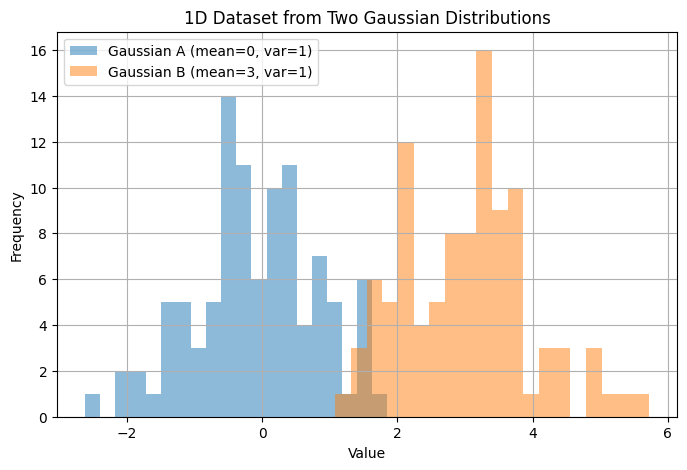

In [4]:
plt.figure(figsize=(8,5))
plt.hist(samples_a, bins=20, alpha=0.5, label='Gaussian A (mean=0, var=1)')
plt.hist(samples_b, bins=20, alpha=0.5, label='Gaussian B (mean=3, var=1)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('1D Dataset from Two Gaussian Distributions')
plt.legend()
plt.grid(True)
plt.savefig(save_dirs[2] + "two_gaussians.png", dpi=300)
plt.show()

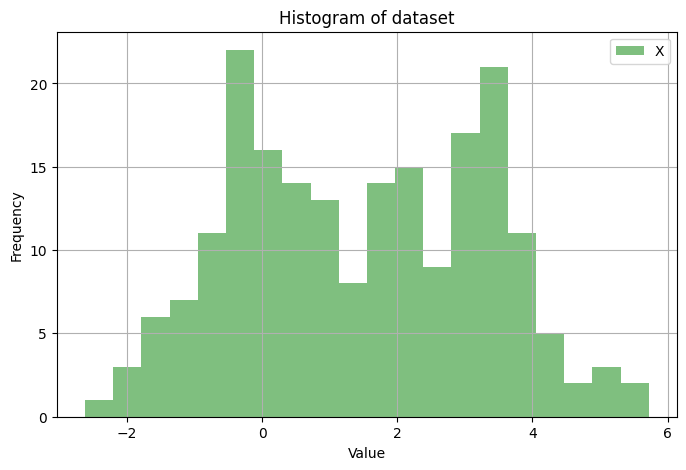

In [5]:
plt.figure(figsize=(8,5))
plt.hist(X, bins=20, label="X", color='green', alpha=0.5)
plt.title('Histogram of dataset')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.savefig(save_dirs[2] + "X_histogram.png", dpi=300)
plt.show()

#### K-means clustering

In [6]:
# Q3.1. K-means clustering
kmeans = KMeans(n_clusters=2, random_state=seed)
kmeans.fit(X)
kmeans_centers = kmeans.cluster_centers_
y_pred_kmeans = kmeans.labels_

if kmeans_centers[0] > kmeans_centers[1]:
    kmeans_centers = kmeans_centers[::-1]
    y_pred_kmeans = 1 - y_pred_kmeans

K-means clustering centers: [-0.2329076   2.92996462]
True centers: [0, 3]
Fraction of points correctly classified: 0.95
Accuracy: 95.50%


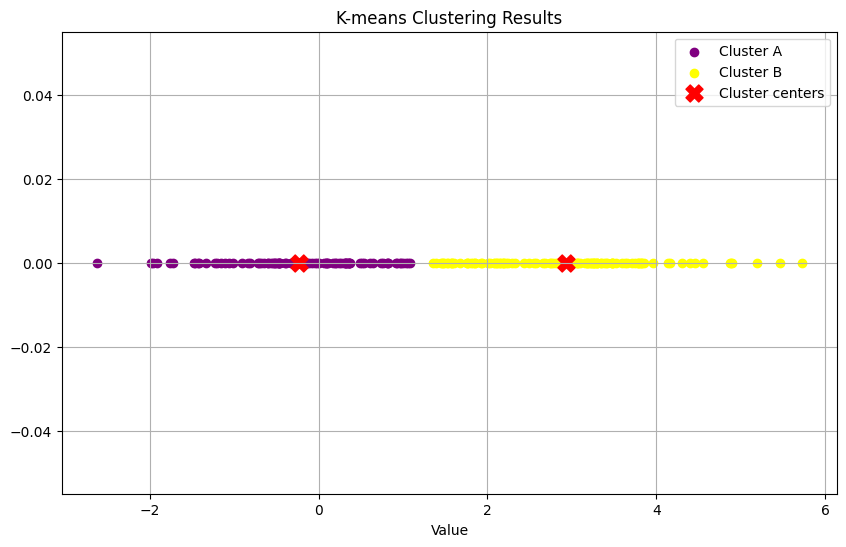

In [7]:
kmeans_accuracy = np.sum(y == y_pred_kmeans) / len(y)
print(f"K-means clustering centers: {np.sort(kmeans_centers.flatten())}")
print(f"True centers: [0, 3]")
print(f"Fraction of points correctly classified: {kmeans_accuracy:.2f}")
print(f"Accuracy: {kmeans_accuracy*100:.2f}%")

plt.figure(figsize=(10, 6))
plt.scatter(X[y_pred_kmeans == 0], np.zeros_like(X[y_pred_kmeans == 0]), c='purple', marker='o', label='Cluster A')
plt.scatter(X[y_pred_kmeans == 1], np.zeros_like(X[y_pred_kmeans == 1]), c='yellow', marker='o', label='Cluster B')
plt.scatter(kmeans_centers, np.zeros_like(kmeans_centers), c='red', marker='X', s=150, label='Cluster centers')
plt.title('K-means Clustering Results')
plt.xlabel('Value')
plt.legend()
plt.grid(True)
plt.savefig(save_dirs[2] + "kmeans_clustering.png", dpi=300)
plt.show()

#### Exhaustive search for k-median clustering 

In [8]:
# Calculate the k-median objective for a given clustering
def k_median_split(X, s):
    X_sorted = np.sort(X.flatten())
    cluster_a = X_sorted[:s]
    cluster_b = X_sorted[s:]
    center_a = np.median(cluster_a)
    center_b = np.median(cluster_b)
    if center_a > center_b:
        center_a, center_b = center_b, center_a
        cluster_a, cluster_b = cluster_b, cluster_a
    cost = np.sum(np.abs(cluster_a - center_a)) + np.sum(np.abs(cluster_b - center_b))
    return cost, np.array([center_a, center_b]).flatten(), (cluster_a, cluster_b)

# Perform exhaustive search over all possible 2-clusterings
n = len(X)
kmedians_cost = float('inf')
kmedians_centers = None
best_split = None

for s in tqdm(range(1, n), desc="Searching for best k-median split", ncols=100):
    cost, centers, clusters = k_median_split(X, s)
    if cost < kmedians_cost:
        kmedians_cost = cost
        best_split = s
        kmedians_centers = centers

print(f"\nBest k-median clustering centers: {np.sort(kmedians_centers)}")
print(f"True centers: [0, 3]")
print(f"Best k-median clustering split: {best_split}")
print(f"Best k-median clustering cost: {kmedians_cost:.2f}")

Searching for best k-median split: 100%|████████████████████████| 199/199 [00:00<00:00, 5520.61it/s]


Best k-median clustering centers: [-0.21967189  3.05820872]
True centers: [0, 3]
Best k-median clustering split: 95
Best k-median clustering cost: 144.42


Fraction of points correctly classified: 0.97
Accuracy: 97.50%


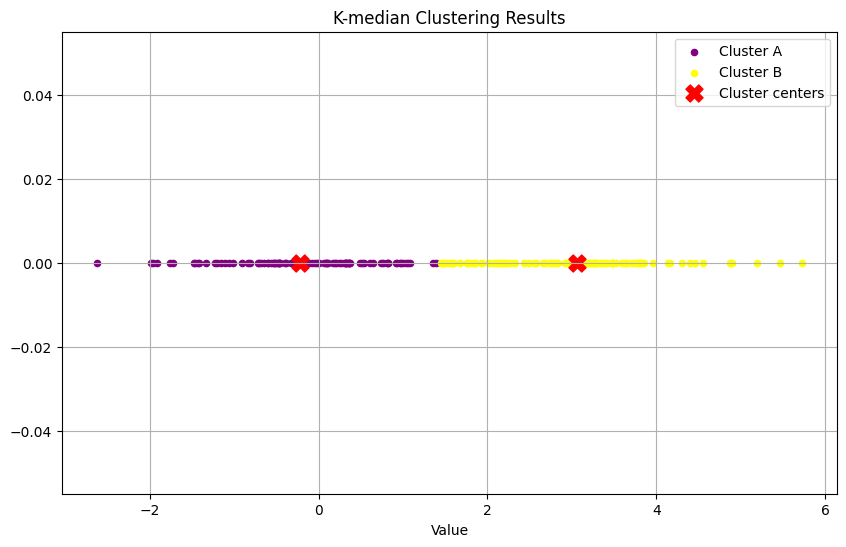

In [9]:
y_pred_kmedians = np.zeros(n, dtype=int)
y_pred_kmedians[:best_split] = 0
y_pred_kmedians[best_split:] = 1
kmedians_accuracy = np.sum(y == y_pred_kmedians) / len(y)
print(f"Fraction of points correctly classified: {kmedians_accuracy:.2f}")
print(f"Accuracy: {kmedians_accuracy*100:.2f}%")

X_sorted = np.sort(X.flatten())
plt.figure(figsize=(10, 6))
plt.scatter(X_sorted[y_pred_kmedians == 0], np.zeros_like(X_sorted[y_pred_kmedians == 0]), c='purple', marker='o', s=20, label='Cluster A')
plt.scatter(X_sorted[y_pred_kmedians == 1], np.zeros_like(X_sorted[y_pred_kmedians == 1]), c='yellow', marker='o', s=20, label='Cluster B')
plt.scatter(kmedians_centers, np.zeros_like(kmedians_centers), c='red', marker='X', s=150, label='Cluster centers')
plt.title('K-median Clustering Results')
plt.xlabel('Value')
plt.legend()
plt.grid(True)
plt.savefig(save_dirs[2] + "kmedian_clustering.png", dpi=300)
plt.show()

In [2]:
print("Comparison of K-means and K-median:")

print(f"\nK-means centers: {np.sort(kmeans_centers.flatten())}")
print(f"K-median centers: {np.sort(kmedians_centers.flatten())}")
print(f"True centers: [0, 3]")

print(f"\nK-means accuracy: {kmeans_accuracy*100:.2f}%")
print(f"K-median accuracy: {kmedians_accuracy*100:.2f}%")

print(f"\nK-means cost (squared distance): {kmeans.inertia_:.2f}")
print(f"K-median cost (absolute distance): {kmedians_cost:.2f}")

print("\nBetter clustering method:", end=" ")
if kmeans.inertia_ < kmedians_cost:
    print("K-means")
else:
    print("K-median")


Comparison of K-means and K-median:

K-means centers: [-0.2329076   2.92996462]
K-median centers: [-0.21967189  3.05820872]
True centers: [0, 3]

K-means accuracy: 95.50%
K-median accuracy: 97.50%

K-means cost (squared distance): 162.60
K-median cost (absolute distance): 144.42

Better clustering method: K-median


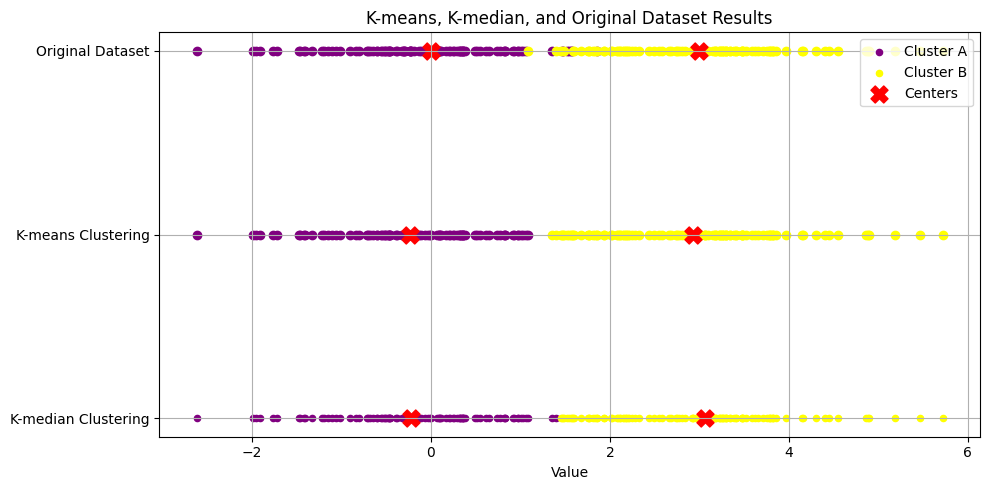

In [11]:
plt.figure(figsize=(10, 5))
# Plot the original dataset (shifted to y = 2)
pos = 2
plt.scatter(samples_a, np.full_like(samples_a, pos), c='purple', marker='o')
plt.scatter(samples_b, np.full_like(samples_b, pos), c='yellow', marker='o')
plt.scatter([0, 3], np.full_like([0, 3], pos), c='red', marker='X', s=150)
# Plot K-means clustering (shifted to y = 1)
pos = 1
plt.scatter(X[y_pred_kmeans==0], np.full_like(X[y_pred_kmeans==0], pos), c='purple', marker='o')
plt.scatter(X[y_pred_kmeans==1], np.full_like(X[y_pred_kmeans==1], pos), c='yellow', marker='o')
plt.scatter(kmeans_centers, np.full_like(kmeans_centers, pos), c='red', marker='X', s=150)
# Plot K-median clustering (shifted to y = 0)
pos = 0
X_sorted = np.sort(X.flatten())
plt.scatter(X_sorted[y_pred_kmedians==0], np.full_like(X_sorted[y_pred_kmedians==0], pos), c='purple', marker='o', s=20, label='Cluster A')
plt.scatter(X_sorted[y_pred_kmedians==1], np.full_like(X_sorted[y_pred_kmedians==1], pos), c='yellow', marker='o', s=20, label='Cluster B')
plt.scatter(kmedians_centers, np.full_like(kmedians_centers, pos), c='red', marker='X', s=150, label='Centers')
plt.title('K-means, K-median, and Original Dataset Results')
plt.xlabel('Value')
plt.yticks([2, 1, 0], ['Original Dataset', 'K-means Clustering', 'K-median Clustering'])
plt.grid(True)
plt.tight_layout()
plt.legend(loc='upper right')
plt.savefig(save_dirs[2] + "combined_results.png", dpi=300)
plt.show()